<ol>

<li> <h2> Incident Data</h2></li>

<ol><h3>
<li><a href="#1"> Histogram for #Incidents/User </a> </li><br>
<li><a href='#2'>For users with 1 incident, number medium, high, critical </a></li><br>
<li><a href='#3.a'>For users with 1 incident, number for each type of Incident - Subtype</a></li><br>
<li><a href='#3.b'>For users with 1 incident, number for each type of incident - Detailed Subtype</a></li><br>
<li><a href='#4'>For users with more than 1 incident, percentage of medium, high, critical</a></li><br>
<li><a href='#5.a'>For users with more than 1 incident, percentage of type of incident - Subtype</a></li><br>
<li><a href='#5.b'>For users with more than 1 incident, percentage of type of incident - Detailed Subtype</a></li><br>
</h3></ol>

<li><h2>Traffic logs</h2></li>

<ol><h3>
<li><a href='#8'>Distribution of # logs/user</a></li><br>
<li><a href='#9'>Distribution of size/user</a></li><br>
<li><a href='#10'>Distribution of duration/user</a></li><br>
</h3></ol>

<li> <h2>Traffic logs and incident data - For users in incident DB </h2></li>
<ol><h3>
<li><a href='#11'>Distribution of # logs/user</a></li><br>
<li><a href='#12'>Distribution of size/user</a></li><br>
<li><a href='#13'>Distribution of duration/user</a></li><br>
</h3></ol>

<li> <h2>Traffic logs and incident data - For users not in incident DB </h2></li>
<ol><h3>
<li><a href='#14'>Distribution of # logs/user</a></li><br>
<li><a href='#15'>Distribution of size/user</a></li><br>
<li><a href='#16'>Distribution of duration/user</a></li><br>
</h3></ol>

</ol>

In [564]:
import os
import progressbar as pb
from progressbar import ProgressBar, Percentage, Bar, ETA, FileTransferSpeed
import time
from numba import jit,autojit
import multiprocessing

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
import pprint
from tabulate import tabulate


import scipy as sp
from scipy import stats



%matplotlib inline
pd.set_option("display.max_columns",80)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings("ignore")

from IPython.display import HTML

import plotly
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
cf.go_offline()
import plotly.tools as tls
import plotly.figure_factory as ff
# tls.set_credentials_file(username='darshan.bhansali', api_key='38zZ2TS4ob4feqV0bvR0')
tls.set_credentials_file(username='darshan-b', api_key='KuC894mmVN7kBiZZyffO')
# tls.set_credentials_file(username='darshan18', api_key='dhwPNrhtYUy2iMbQqALn')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
traffic_column_names =['Recorded_Time','Received_Time','Serial_Number','Type','Subtype','Config_Version','Generated_Time',
               'Source_IP','Destination_IP','NAT_Source_IP','NAT_Destination_IP','Rule_Name','Source_User','Destination_User',
               'Application','Virtual_System','Source_Zone','Destination_Zone','Ingress_Interface','Egress_Interface',
               'Log_Forwarding_Profile','Future_Use','Session_ID','Repeat_Count','Source_Port','Destination_Port',
               'NAT_Source_Port','NAT_Destination_Port','Flags','Protocol','Action','Bytes','Bytes_sent','Bytes_received',
               'Packets','Start_Time','Elapsed_Time','Category','Future_Use_1','Sequence_Number','Action_flags','Source_Location',
               'Destination_Location', 'Future_Use_2', 'Packets Sent', 'Packets Received', 'Session End Reason','Drop_1','Drop_2',
               'Drop_3','Drop_4','Drop_5','device_name','From_Policy','a','b','c','d','e','f','g']

threat_column_names=['Recorded_Time','Received_Time','Serial_Number','Type','Subtype', 'Config_Version','Generated_Time',
                     'Source_IP','Destination_IP','NAT_Source_IP','NAT_Destination_IP','Rule_Name','Source_User','Destination_User',
                     'Application','Virtual_System','Source_Zone','Destination_Zone','Ingress_Interface','Egress_Interface', 
                     'Log_Forwarding_Profile','Future_Use','Session_ID','Repeat_Count','Source_Port','Destination_Port', 
                     'NAT_Source_Port','NAT_Destination_Port','Flags','Protocol','Action', 'Miscellaneous','Threat_ID', 
                     'Category', 'Severity', 'Direction','Sequence_Number', 'Action_Flags','Source_Location','Destination_Location',
                     'Drop_40','Drop_41','Drop_42','Drop_43','Drop_44','Something','Drop_46','Drop_47','Drop_48','Drop_49',
                     'Drop_50','Drop_51','Drop_52','Drop_53','Drop_54','Drop_55','Drop_56','Drop_57','Drop_58',
                     'device_name','Drop_60','Drop_61','Drop_62','Drop_63','Drop_64','Drop_65','Drop_66','Drop_67','Drop_68',
                     'Detailed_Subtype','Something_2','From_Policy']

In [3]:
def read_logs(rel_path,compression=None,extension=None,column_names=None):
    path = rel_path
    zip_files = [f for f in os.listdir(path) if f.endswith(extension)]
    paths = [path + x for x in zip_files]
    df=pd.DataFrame()
    for i in range(0,len(paths)):
        try:
            demo_df=pd.read_csv(paths[i],header=None,infer_datetime_format=True,low_memory=True,
                                compression=compression,error_bad_lines=False,warn_bad_lines=False,memory_map=True)
        except:
            print(i,paths[i],"\n")
            continue
        if demo_df.empty!=True:
            df=df.append(demo_df)
        else:
            print("Not empty")
    df.columns=column_names
    return df

In [4]:
root_paths=['../../data/2017-09-26/','../../data/2017-09-27/','../../data/2017-09-28/','../../data/2017-09-29/',
            '../../data/2017-09-30/','../../data/2017-10-01/','../../data/2017-10-02/','../../data/2017-10-03/',
            '../../data/2017-10-04/','../../data/2017-10-05/','../../data/2017-10-06/','../../data/2017-10-07/',
            '../../data/2017-10-08/','../../data/2017-10-09/','../../data/2017-10-10/','../../data/2017-10-11/'
           ,'../../data/2017-10-12/','../../data/2017-10-13/','../../data/2017-10-14/','../../data/2017-10-15/'
           ,'../../data/2017-10-16/']

threat_logs=pd.DataFrame()
for i in range(0,len(root_paths)):
    df2=(read_logs(root_paths[i],None,'Wireless-PA.csv',threat_column_names))
    threat_logs=pd.concat([threat_logs,df2])
threat_logs.Received_Time=pd.to_datetime(threat_logs.Received_Time)
threat_logs.sort_values(by='Received_Time',inplace=True)
threat_logs.dropna(inplace=True,subset=['Source_User'])
threat_logs.reset_index(inplace=True,drop=True)

threat_logs.drop(['Drop_40','Drop_41','Drop_42','Drop_43','Drop_44','Drop_46','Drop_47','Drop_48','Drop_49',
                 'Drop_50','Drop_51','Drop_52','Drop_53','Drop_54','Drop_55','Drop_56','Drop_57','Drop_58',
                 'Drop_60','Drop_61','Drop_62','Drop_63','Drop_64','Drop_65','Drop_65','Drop_66','Drop_67',
                 'Drop_68',
                 'NAT_Source_IP','NAT_Destination_IP','Rule_Name','Destination_User','Virtual_System',
                 'Log_Forwarding_Profile','NAT_Source_Port','NAT_Destination_Port','Action_Flags','From_Policy',
                 'Flags','Serial_Number','Config_Version','Source_Zone','Destination_Zone','Ingress_Interface',
                'Egress_Interface'],
                axis=1,inplace=True)

In [5]:
def read_traffic():
    traffic_logs=pd.DataFrame()
    for i in range(0,len(root_paths)):
        df2=(read_logs(root_paths[i],'gzip','.gz',traffic_column_names))
        traffic_logs=pd.concat([traffic_logs,df2])
    return traffic_logs
traffic_logs=read_traffic()
traffic_logs.drop(['a','b','c','d','e','f','g','From_Policy','Drop_1','Drop_2','Drop_3','Drop_4','Drop_5',
                   'Future_Use_2','Action_flags','Future_Use_1','NAT_Source_Port','NAT_Destination_Port',
               ""    'NAT_Source_IP','NAT_Destination_IP','Rule_Name','Destination_User','Virtual_System',
                   'Log_Forwarding_Profile','Serial_Number','Config_Version','Source_Zone','Destination_Zone',
                   'Ingress_Interface','Egress_Interface'],axis=1,inplace=True)
traffic_logs.Received_Time=pd.to_datetime(traffic_logs.Received_Time,errors='coerce')
traffic_logs.sort_values(by='Received_Time',inplace=True)
traffic_logs.dropna(inplace=True,subset=['Source_User'])
traffic_logs.reset_index(inplace=True,drop=True)

6 ../../data/2017-09-30/2017-09-30_11_Traffic_Wireless-PA.csv.gz 

11 ../../data/2017-09-30/2017-09-30_10_Traffic_Wireless-PA.csv.gz 

16 ../../data/2017-09-30/2017-09-30_09_Traffic_Wireless-PA.csv.gz 

6 ../../data/2017-10-04/2017-10-04_00_Traffic_Wireless-PA.csv.gz 

0 ../../data/2017-10-07/2017-10-07_03_Traffic_Wireless-PA.csv.gz 

15 ../../data/2017-10-07/2017-10-07_02_Traffic_Wireless-PA.csv.gz 

10 ../../data/2017-10-10/2017-10-10_20_Traffic_Wireless-PA.csv.gz 



## 1. Incident Data

In [461]:
print("The period for which the analysis has been performed is from {} to {}".format(threat_logs.Received_Time.min(),
                                                                                    threat_logs.Received_Time.max()))
print("{} unique users exist in the threat logs".format(threat_logs.Source_User.nunique()))
print("{} records exist in the threat logs for the given period".format(len(threat_logs)))

The period for which the analysis has been performed is from 2017-09-26 19:59:22 to 2017-10-16 23:59:46
846 unique users exist in the threat logs
6115 records exist in the threat logs for the given period


### <a id='1'>A.  Histogram of #incidents/#users (bins for both)


In [462]:
d=pd.DataFrame(threat_logs.Source_User.value_counts())
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Count']
d_le1=d[d.Count==1]
d_ge1=d[d.Count>1]

In [463]:
trace = go.Histogram(x=d.Count)

layout=go.Layout(title='Histogram of # Incidents/User',
                 xaxis=dict(title='Count of repeat incidents',tickangle=0),
                 yaxis=dict(title='Number of Users'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Histogram_Full')

In [464]:
print("Only {} users  have more than 20 threat incidents\nOnly {} users have more than 50 threat incidents\nOnly {} users have more than 100 threat incidents"
      .format(sum(d.Count>20),sum(d.Count>50),sum(d.Count>100)))

Only 26 users  have more than 20 threat incidents
Only 15 users have more than 50 threat incidents
Only 6 users have more than 100 threat incidents


In [465]:
print("Lets plot the histogram for users with less than 20 incidents")
trace = go.Histogram(x=d.Count,xbins=dict(start=0,end=20))

layout=go.Layout(title='Histogram of # Incidents/User',
                 xaxis=dict(title='Count of repeat incidents',tickangle=0),
                 yaxis=dict(title='Number of Users'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Histogram_20')

Lets plot the histogram for users with less than 20 incidents


In [466]:
print("Lets plot the histogram for users with less than 50 incidents")
trace = go.Histogram(x=d.Count,xbins=dict(start=0,end=50))

layout=go.Layout(title='Histogram of # Incidents/User',
                 xaxis=dict(title='Count of repeat incidents',tickangle=0),
                 yaxis=dict(title='Number of Users'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Histogram_50')

Lets plot the histogram for users with less than 50 incidents


In [467]:
print("Lets plot the histogram for users with less than 100 incidents")
trace = go.Histogram(x=d.Count,xbins=dict(start=0,end=100))

layout=go.Layout(title='Histogram of # Incidents/User',
                 xaxis=dict(title='Count of repeat incidents',tickangle=0),
                 yaxis=dict(title='Number of Users'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Histogram_100')

Lets plot the histogram for users with less than 100 incidents


### <a id='2'>B. For users with 1 incident, number medium, high, critical


In [468]:
d=threat_logs.groupby([threat_logs.Source_User,threat_logs.Severity]).count().unstack().fillna(0)['Subtype']
c=pd.DataFrame(d)
c.reset_index(inplace=True,drop=False)
c['Count']=c.critical+c.high+c.medium
c.sort_values(by='Count',ascending=False,inplace=True)
c.Count=c.Count.astype(int)
c.reset_index(inplace=True,drop=True)
x=c[c.Count<=1]
y=c[c.Count>1]

In [469]:
print("The table below illustrates the number of incidents for Users with 1 incident in the threat logs by Severity")
print("\n-----------------------------------------------------------------------------------------------------------\n")
print(tabulate(x[['Source_User','critical','high','medium']],headers=['Source User','Critical','High','Medium'],tablefmt='grid'))

The table below illustrates the number of incidents for Users with 1 incident in the threat logs by Severity

-----------------------------------------------------------------------------------------------------------

+-----+------------------------------------------------------------------+------------+--------+----------+
|     | Source User                                                      |   Critical |   High |   Medium |
+=====+==================================================================+============+========+==========+
| 393 | a56e530cb71d921e2a06cb8a11f05497dbb11ad47f38f2e2642c50c8ee7732c7 |          0 |      0 |        1 |
+-----+------------------------------------------------------------------+------------+--------+----------+
| 394 | b4abf347596882503b36d7e3f0d69ca7de239f191e3214321351d14d982ef499 |          0 |      0 |        1 |
+-----+------------------------------------------------------------------+------------+--------+----------+
| 395 | aaca5cdcccf23e9d5

In [470]:
print("Summary table for users with 1 incident by severity")
z=pd.DataFrame(x.sum())
print(tabulate([{'Critical':x.critical.sum(),'High':x.high.sum(),'Medium':x.medium.sum()}],
               headers={'Critical':'Critical','High':'High','Medium':'Medium'},tablefmt='grid'))

Summary table for users with 1 incident by severity
+------------+--------+----------+
|   Critical |   High |   Medium |
+============+========+==========+
|          3 |      8 |      441 |
+------------+--------+----------+


In [471]:
d=threat_logs.groupby([threat_logs.Source_User,threat_logs.Subtype]).count().unstack().fillna(0)['Severity']
c=pd.DataFrame(d)
c.reset_index(inplace=True,drop=False)
c['Count']=c.spyware+c.vulnerability
c.sort_values(by='Count',ascending=False,inplace=True)
c.Count=c.Count.astype(int)
c.reset_index(inplace=True,drop=True)
x=c[c.Count<=1]
y=c[c.Count>1]

In [472]:
print("The table below illustrates the number of incidents for Users with 1 incident in the threat logs by Incident")
print("\n---------------------------------------------------------------------------------------------------------------------\n")
print(tabulate(x[['Source_User','spyware','vulnerability']],headers=['Source_User','spyware','vulnerability'],tablefmt='grid'))

The table below illustrates the number of incidents for Users with 1 incident in the threat logs by Incident

---------------------------------------------------------------------------------------------------------------------

+-----+------------------------------------------------------------------+-----------+-----------------+
|     | Source_User                                                      |   spyware |   vulnerability |
+=====+==================================================================+===========+=================+
| 393 | ef03d74e4e072361f2c6a9a48d3ff04218c45b5f144b40d6bc46a285a3d9f535 |         1 |               0 |
+-----+------------------------------------------------------------------+-----------+-----------------+
| 394 | ee15050146c22a4b080c0518abcd868d38809b6ac450750698fadec3f2be2287 |         1 |               0 |
+-----+------------------------------------------------------------------+-----------+-----------------+
| 395 | ee5d3aa446b8deda0193b3c49001

In [473]:
print("Summary table for users with 1 incident by type of incident")
z=pd.DataFrame(x.sum())
print(tabulate([{'Spyware':x.spyware.sum(),'Vulnerability':x.vulnerability.sum()}],
               headers={'Spyware':'Spyware','Vulnerability':'Vulnerability'},tablefmt='grid'))

Summary table for users with 1 incident by type of incident
+-----------+-----------------+
|   Spyware |   Vulnerability |
+===========+=================+
|       434 |              18 |
+-----------+-----------------+


### <a id='3.b'> D. For users with 1 incident, number for each type of Detailed Subtype

In [474]:
d=threat_logs.groupby([threat_logs.Source_User,threat_logs.Detailed_Subtype]).count().unstack().fillna(0)['Severity']
c=pd.DataFrame(d)
c.reset_index(inplace=True,drop=False)
c['Count']=c[c.columns[1:]].sum(axis=1)
c.sort_values(by='Count',ascending=False,inplace=True)
c.Count=c.Count.astype(int)
c.reset_index(inplace=True,drop=True)
x=c[c.Count<=1]
y=c[c.Count>1]

In [475]:
print("The table below illustrates the number of incidents for Users with 1 incident in the threat logs by Detailed Subtype")
print("\n---------------------------------------------------------------------------------------------------------------------\n")
x.iloc[:,:-1]

The table below illustrates the number of incidents for Users with 1 incident in the threat logs by Detailed Subtype

---------------------------------------------------------------------------------------------------------------------



Detailed_Subtype,Source_User,brute-force,code-execution,dns,dns-wildfire,dos,info-leak,overflow,spyware,sql-injection
393,a56e530cb71d921e2a06cb8a11f05497dbb11ad47f38f2...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
394,b4abf347596882503b36d7e3f0d69ca7de239f191e3214...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
395,aaca5cdcccf23e9d5f1debe1ec0528fc5550ffe99f2f4a...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
396,aae33f99f3b8e226134b0a388e1392e2fa07e0b7371112...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
397,ad83c973582e61a5a8f835290abbba7905c6419dc3f2c0...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
398,adedc265e5231a92104bc66a625c155fc15445ea36312d...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
399,aaffb0f4e1aaaf8f63d821569e1404bdce5859fd752d62...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
400,ae67d5bfe67edc587454affa2ea45a82225be653837c66...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
401,ad93b36a16702743ed28b944b13c74840d77840b65389f...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
402,b51e7774251c7abac2116b2c7361bc672f60df7e879460...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [476]:
print("Summary table for users with 1 incident by Detailed type of incident")
z=pd.DataFrame(x.sum())
print(tabulate([{'brute-force':x['brute-force'].sum(),'code-execution':x['code-execution'].sum(),
                 'dns':x['dns'].sum(),'dns-wildfire':x['dns-wildfire'].sum(), 'dos':x['dos'].sum(),
                 'info-leak':x['info-leak'].sum(), 'overflow':x['overflow'].sum(),'spyware':x['spyware'].sum(),
                 'sql-injection':x['sql-injection'].sum()}],
               headers={'brute-force':'brute-force','code-execution':'code-execution', 'dns':'dns',
                        'dns-wildfire':'dns-wildfire', 'dos':'dos', 'info-leak':'info-leak',
                        'overflow':'overflow', 'spyware':'spyware','sql-injection':'sql-injection'},tablefmt='grid'))

Summary table for users with 1 incident by Detailed type of incident
+---------------+------------------+-------+----------------+-------+-------------+------------+-----------+-----------------+
|   brute-force |   code-execution |   dns |   dns-wildfire |   dos |   info-leak |   overflow |   spyware |   sql-injection |
+===============+==================+=======+================+=======+=============+============+===========+=================+
|             4 |                1 |   360 |             71 |     4 |           4 |          3 |         3 |               2 |
+---------------+------------------+-------+----------------+-------+-------------+------------+-----------+-----------------+


### <a id='4'>E. For users with more than 1 incident, percentage of medium, high, critical

In [566]:
d=threat_logs.groupby([threat_logs.Source_User,threat_logs.Severity]).count().unstack().fillna(0)['Subtype']
c=pd.DataFrame(d)
c.reset_index(inplace=True,drop=False)
c['Count']=c.critical+c.high+c.medium
c.sort_values(by='Count',ascending=False,inplace=True)
c.Count=c.Count.astype(int)
c.reset_index(inplace=True,drop=True)
x=c[c.Count<=1]
y=c[c.Count>1]

In [567]:
print("Summary table for users with more than 1 incident by severity in Percentage")
z=pd.DataFrame(y.sum())
print(tabulate([{'Critical':y.critical.sum(),'High':y.high.sum(),'Medium':y.medium.sum()}],
               headers={'Critical':'Critical','High':'High','Medium':'Medium'},tablefmt='grid'))

Summary table for users with more than 1 incident by severity in Percentage
+------------+--------+----------+
|   Critical |   High |   Medium |
+============+========+==========+
|         56 |    802 |     4798 |
+------------+--------+----------+


In [568]:
y.critical=y.critical/(y.Count)
y.medium=y.medium/(y.Count)
y.high=y.high/(y.Count)
print("The table below illustrates the percetange of incidents for Users with more than 1 incident in the threat logs by Severity")
print("\n-----------------------------------------------------------------------------------------------------------\n")
print(tabulate(y[['Source_User','critical','high','medium']],headers=['Source User','Critical %','High %','Medium %'],tablefmt='grid'))

The table below illustrates the percetange of incidents for Users with more than 1 incident in the threat logs by Severity

-----------------------------------------------------------------------------------------------------------

+-----+------------------------------------------------------------------+--------------+-----------+------------+
|     | Source User                                                      |   Critical % |    High % |   Medium % |
+=====+==================================================================+==============+===========+============+
|   0 | e0027ef4773a01094339852b6b1207f38c22adbe46879a9faf490413b580caab |   0.00123001 | 0.0356704 |   0.9631   |
+-----+------------------------------------------------------------------+--------------+-----------+------------+
|   1 | 07a805db92f77828144af02c110b4107381c8608ff69cbe8322b1619550dca26 |   0          | 1         |   0        |
+-----+------------------------------------------------------------------+---

In [569]:
trace=go.Scatter3d(x=y.critical,y=y.high,z=y.medium)
layout=go.Layout(title='Scatter plot',)
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='1')

#### The scatter plot is such because, most of the users, even though how more than 1 incident, have incident belonging to the same subtype

### <a id='5.a'> F. For users with more than 1 incident, percentage of type of incident - Subtype

In [480]:
d=threat_logs.groupby([threat_logs.Source_User,threat_logs.Subtype]).count().unstack().fillna(0)['Severity']
c=pd.DataFrame(d)
c.reset_index(inplace=True,drop=False)
c['Count']=c[c.columns[1:]].sum(axis=1)
c.sort_values(by='Count',ascending=False,inplace=True)
c.Count=c.Count.astype(int)
c.reset_index(inplace=True,drop=True)
y=c[c.Count>1]

In [481]:
print("Summary table for users with more than 1 incident by type of incident in percentage")
z=pd.DataFrame(y.sum())
print(tabulate([{'Spyware':y.spyware.sum(),'Vulnerability':y.vulnerability.sum()}],
               headers={'Spyware':'Spyware','Vulnerability':'Vulnerability'},tablefmt='grid'))

Summary table for users with more than 1 incident by type of incident in percentage
+-----------+-----------------+
|   Spyware |   Vulnerability |
+===========+=================+
|      3467 |            2189 |
+-----------+-----------------+


In [482]:
y.spyware=y.spyware/(y.Count)
y.vulnerability=y.vulnerability/(y.Count)
print("The table below illustrates the percetange of incidents for Users with more than 1 incident in the threat logs by Incident")
print("\n-----------------------------------------------------------------------------------------------------------\n")
print(tabulate(y[['Source_User','spyware','vulnerability']],headers=['Source User','Spyware %','Vulnerability %'],tablefmt='grid'))

The table below illustrates the percetange of incidents for Users with more than 1 incident in the threat logs by Incident

-----------------------------------------------------------------------------------------------------------

+-----+------------------------------------------------------------------+-------------+-------------------+
|     | Source User                                                      |   Spyware % |   Vulnerability % |
+=====+==================================================================+=============+===================+
|   0 | e0027ef4773a01094339852b6b1207f38c22adbe46879a9faf490413b580caab |     0.96187 |         0.0381304 |
+-----+------------------------------------------------------------------+-------------+-------------------+
|   1 | 07a805db92f77828144af02c110b4107381c8608ff69cbe8322b1619550dca26 |     0       |         1         |
+-----+------------------------------------------------------------------+-------------+-------------------+
|   

### <a id='5.b'> G. For users with more than 1 incident, percentage of type of incident - Detailed Subtype

In [483]:
d=threat_logs.groupby([threat_logs.Source_User,threat_logs.Detailed_Subtype]).count().unstack().fillna(0)['Severity']
c=pd.DataFrame(d)
c.reset_index(inplace=True,drop=False)
c['Count']=c[c.columns[1:]].sum(axis=1)
c.sort_values(by='Count',ascending=False,inplace=True)
c.Count=c.Count.astype(int)
c.reset_index(inplace=True,drop=True)
y=c[c.Count>1]

In [484]:
print("Summary table for users with more than 1 incident by Detailed type of incident in percentages")
z=pd.DataFrame(y.sum())
print(tabulate([{'brute-force':y['brute-force'].sum(),'code-execution':y['code-execution'].sum(),
                 'dns':y['dns'].sum(),'dns-wildfire':y['dns-wildfire'].sum(), 'dos':y['dos'].sum(),
                 'info-leak':y['info-leak'].sum(), 'overflow':y['overflow'].sum(),'spyware':y['spyware'].sum(),
                 'sql-injection':y['sql-injection'].sum()}],
               headers={'brute-force':'bruteforce','code-execution':'codeexecution', 'dns':'dns',
                        'dns-wildfire':'dnswildfire', 'dos':'dos', 'info-leak':'info-leak',
                        'overflow':'overflow', 'spyware':'spyware','sql-injection':'sql-injection'},tablefmt='grid'))

Summary table for users with more than 1 incident by Detailed type of incident in percentages
+--------------+-----------------+-------+---------------+-------+-------------+------------+-----------+-----------------+
|   bruteforce |   codeexecution |   dns |   dnswildfire |   dos |   info-leak |   overflow |   spyware |   sql-injection |
+==============+=================+=======+===============+=======+=============+============+===========+=================+
|          718 |              17 |  2637 |           440 |  1124 |          69 |        248 |       390 |              12 |
+--------------+-----------------+-------+---------------+-------+-------------+------------+-----------+-----------------+


In [485]:
b=y.columns.get_values()[:-1]
b=b[1:]
for i in range(0,len(b)):
    y[b[i]]=y[b[i]]/(y.Count)
print("Table below illustrates the percetange of incidents for Users with more than 1 incident in the threat logs by Detailed Subtype")
print("\n-------------------------------------------------------------------------------------------------------------------------------\n")
y.reset_index(drop=True,inplace=True)
y.iloc[:,:-1]

Table below illustrates the percetange of incidents for Users with more than 1 incident in the threat logs by Detailed Subtype

-------------------------------------------------------------------------------------------------------------------------------



Detailed_Subtype,Source_User,brute-force,code-execution,dns,dns-wildfire,dos,info-leak,overflow,spyware,sql-injection
0,e0027ef4773a01094339852b6b1207f38c22adbe46879a...,0.03321,0.001230,0.836408,0.125461,0.00246,0.001230,0.0,0.000000,0.000000
1,07a805db92f77828144af02c110b4107381c8608ff69cb...,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000
2,eb30caaced9156871a8c10b8f96924d1dd57bc3bfbcbf0...,0.00000,0.000000,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.000000
3,e931f318e6d489b8c1fefcdbcc9f1678c3f5fc95b51fa9...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,1.000000,0.000000
4,9da2d1a02cd95e57b98d0f8e631ad2fcf7d0b8c5ff94a5...,0.00000,0.000000,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.000000
5,1d87fa38d0fe0ba141f715757c6ae4ef2b44d114c702c7...,0.00000,0.000000,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.000000
6,271be6dd221205698a91c021260cf5bf4deb604945a2e8...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.000000
7,eee73a52c55dbef6c5b4ec7ec0cd3d200a90f528b7344b...,0.00000,0.164835,0.000000,0.000000,0.00000,0.703297,0.0,0.000000,0.131868
8,64c7c7ab1002f853fec50dcb65b8d4ce104aa67df24a11...,0.00000,0.000000,0.955556,0.044444,0.00000,0.000000,0.0,0.000000,0.000000
9,6b0394c114737385c681063f719ccbd4217d866a8984ab...,0.00000,0.000000,0.000000,0.000000,1.00000,0.000000,0.0,0.000000,0.000000


The correlation between detailed subtype:


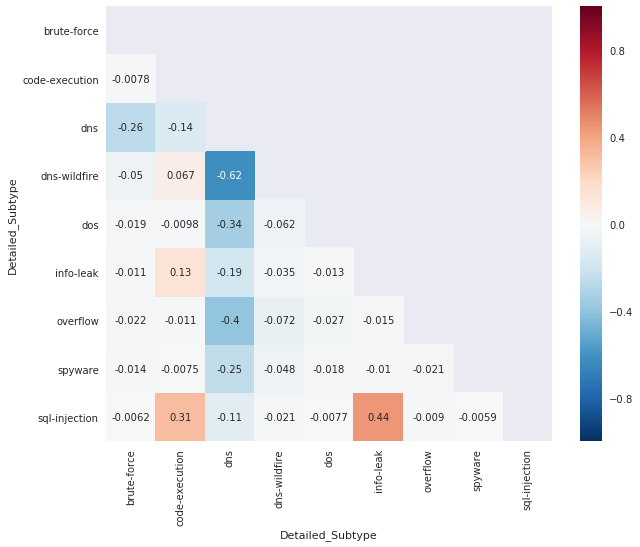

In [486]:
print("The correlation between detailed subtype:")
corr=y[['brute-force','code-execution', 'dns','dns-wildfire', 'dos', 'info-leak','overflow', 'spyware','sql-injection']].corr()
sns.axes_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True           
plt.figure(figsize=(10,8))
sns.heatmap(data=corr,annot=corr,mask=mask)
plt.show()

## 2. Traffic Logs

In [487]:
print("The period for which the analysis has been performed on Traffic Logs is is from {} to {}".format(traffic_logs.Received_Time.min(),
                                                                                    traffic_logs.Received_Time.max()))
print("{} unique users exist in the Traffic Logs".format(traffic_logs.Source_User.nunique()))
print("{} records exist in the Traffic Logs for the given period".format(len(traffic_logs)))

The period for which the analysis has been performed on Traffic Logs is is from 2017-09-25 23:42:10 to 2017-10-16 22:59:48
47779 unique users exist in the Traffic Logs
24321769 records exist in the Traffic Logs for the given period


### <a id='8'> A. Distribution of # logs/user 

In [488]:
d=pd.DataFrame(traffic_logs.Source_User.value_counts())
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Count']

In [489]:
n,min_max,avg,var,skew,kurtosis=stats.describe(d.Count)
print(tabulate([['Unique Users',n],['Minimum #logs/user',min_max[0]], ["Maximum #logs/User",min_max[1]],
               ['Average #logs/user',avg],['Std.dev #logs/user',sp.std(d.Count)],['Variance #logs/user',var],
                ['Skewness #logs/user',skew],['Kurtosis #logs/user',kurtosis], ['Std error of mean',stats.sem(d.Count)],
                ['Median #logs/user',np.median(d.Count)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the #logs/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data")
print("Also the mean is larger than the median which means we have a positive skew")

+---------------------+------------------+
| Measures            |           Values |
+=====================+==================+
| Unique Users        |   47779.00000000 |
+---------------------+------------------+
| Minimum #logs/user  |       1.00000000 |
+---------------------+------------------+
| Maximum #logs/User  |  145869.00000000 |
+---------------------+------------------+
| Average #logs/user  |     509.04725926 |
+---------------------+------------------+
| Std.dev #logs/user  |    1142.82682874 |
+---------------------+------------------+
| Variance #logs/user | 1306080.49636420 |
+---------------------+------------------+
| Skewness #logs/user |      63.13859669 |
+---------------------+------------------+
| Kurtosis #logs/user |    7051.50835458 |
+---------------------+------------------+
| Std error of mean   |       5.22837157 |
+---------------------+------------------+
| Median #logs/user   |     197.00000000 |
+---------------------+------------------+


We can cl

Let us plot a distibution of #Logs/user


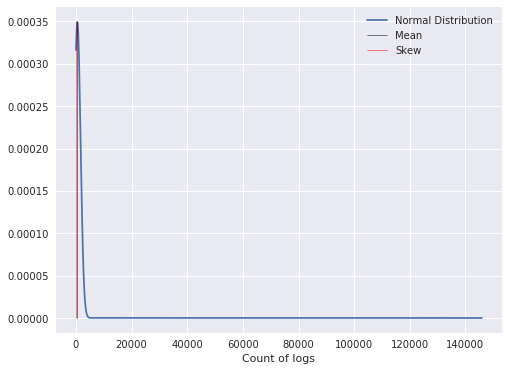

In [490]:
print("Let us plot a distibution of #Logs/user")
plt.figure(figsize=(8,6))
pdf = stats.norm.pdf(d.Count, avg, sp.std(d.Count))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00035], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0 ,0.00035],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Count of logs")
plt.legend()
plt.show()

In [491]:
print("The number of logs/user is greater than 5000 in only {} cases".format(sum(d.Count>5000)))
print("Let us take a closer look at the above distribution graph")

The number of logs/user is greater than 5000 in only 95 cases
Let us take a closer look at the above distribution graph


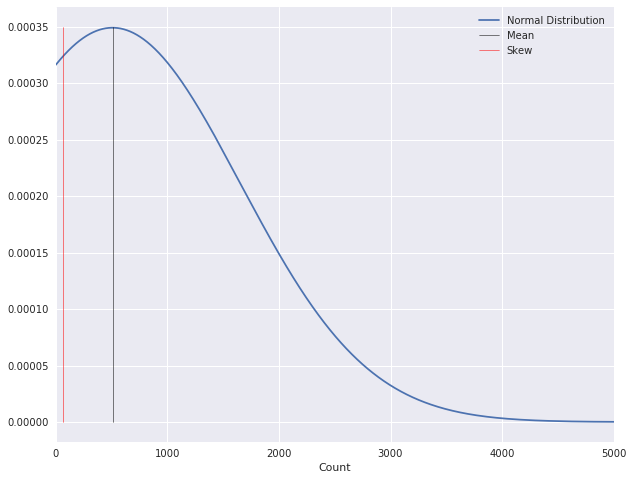

In [492]:
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(d.Count, avg, sp.std(d.Count))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00035], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0,0.00035],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Count")
plt.legend()
plt.xlim(0,5000)
plt.show()

In [493]:
print("Let us convert the count to log and then see the distribution")

Let us convert the count to log and then see the distribution


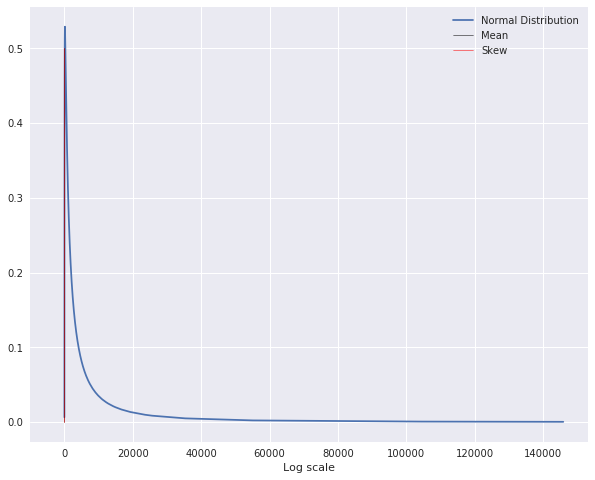

In [494]:
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(np.log10(d.Count), np.mean(np.log10(d.Count)), sp.std(np.log10(d.Count)))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([np.log10(avg), np.log10(avg)], [0, 0.5], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([np.log10(skew),np.log10(skew)],[0,0.5],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlim(-10000)
plt.xlabel("Log scale")
plt.legend()
plt.show()

lets plot a box plot which will re-affirm the above results


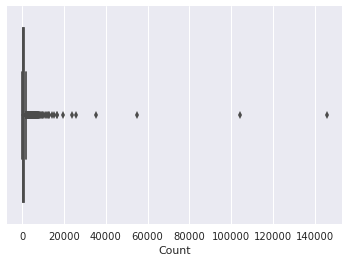

In [495]:
print("lets plot a box plot which will re-affirm the above results")
sns.boxplot(x=d.Count,color='red')
plt.show()

In [496]:
print("The boxplot shows the heavy skew in data")

The boxplot shows the heavy skew in data


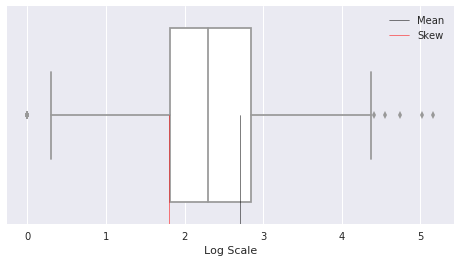

In [497]:
plt.figure(figsize=(8,4))
sns.boxplot(x=np.log10(d.Count),color='white')
plt.plot([np.log10(avg), np.log10(avg)], [0, 15], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([np.log10(skew),np.log10(skew)],[0,10],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Log Scale")
plt.legend()
plt.show()

In [498]:
d.Source_User=np.arange(0,len(d))
print("The below graph illustartes the distribution of number of logs per user.\nAs there are {} unique users in the traffic logs, they will not be displayed appropriately on the X-axis\nHence I have converted Source User names to integers for simplicity".format(traffic_logs.Source_User.nunique()))
trace=go.Bar(x=d.Source_User,y=d.Count)
layout=go.Layout(title='Distribution of # Logs/User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='# of Logs'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Full_Traffic')

The below graph illustartes the distribution of number of logs per user.
As there are 47779 unique users in the traffic logs, they will not be displayed appropriately on the X-axis
Hence I have converted Source User names to integers for simplicity
The draw time for this plot will be slow for clients without much RAM.


### <a id='9'> B. Distribution of Size/User </a>

In [499]:
c=traffic_logs.groupby(traffic_logs.Source_User).sum()['Bytes']
c=pd.DataFrame(c)
c.reset_index(inplace=True)
c.sort_values(by='Bytes',inplace=True,ascending=True)
c.Bytes=c.Bytes/1000000.0

In [500]:
print("Converted packet size from bytes to MB")
n,min_max,avg,var,skew,kurtosis=stats.describe(c.Bytes)
print(tabulate([['Unique Users',n],
               ['Average packet_size/user',avg],['Std.dev packet_size/user',sp.std(c.Bytes)],['Variance packet_size/user',var],
                ['Skewness packet_size/user',skew],['Kurtosis packet_size/user',kurtosis], ['Std error of mean',stats.sem(c.Bytes)],
                ['Median packet_size/user',np.median(c.Bytes)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the packet size/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data same as in previous case")
print("Also the mean is larger than the median which means we have a positive skew")

Converted packet size from bytes to MB
+---------------------------+-----------------+
| Measures                  |          Values |
+===========================+=================+
| Unique Users              |  47779.00000000 |
+---------------------------+-----------------+
| Average packet_size/user  |    103.56160740 |
+---------------------------+-----------------+
| Std.dev packet_size/user  |    345.28032103 |
+---------------------------+-----------------+
| Variance packet_size/user | 119220.99535055 |
+---------------------------+-----------------+
| Skewness packet_size/user |     16.47196479 |
+---------------------------+-----------------+
| Kurtosis packet_size/user |    532.85362936 |
+---------------------------+-----------------+
| Std error of mean         |      1.57963899 |
+---------------------------+-----------------+
| Median packet_size/user   |     11.32219300 |
+---------------------------+-----------------+


We can clearly see that the variance in the pac

Let us plot a distibution of packet_size/user


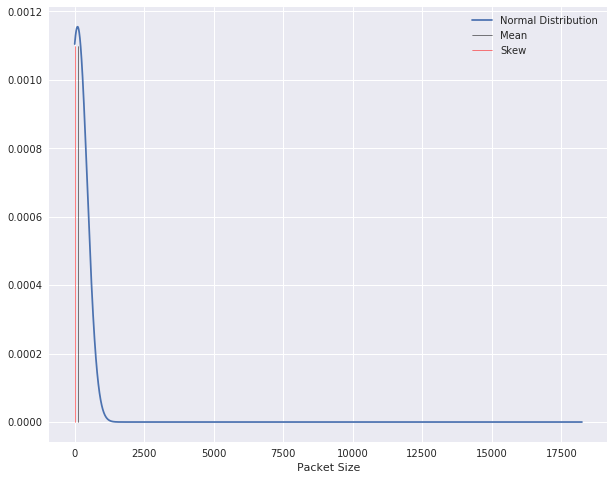

In [501]:
print("Let us plot a distibution of packet_size/user")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(c.Bytes, avg, sp.std(c.Bytes))
plt.plot(c.Bytes, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.0011], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.0011],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.legend()
plt.show()

In [502]:
print("The packet_size/user is greater than 5GB in only {} cases".format(sum(c.Bytes>5000)))
print("Let us take a closer look at the above distribution graph")

The packet_size/user is greater than 5GB in only 33 cases
Let us take a closer look at the above distribution graph


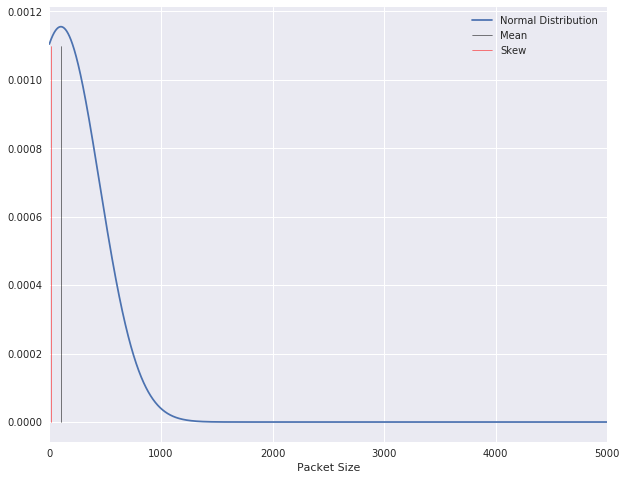

In [503]:
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(c.Bytes, avg, sp.std(c.Bytes))
plt.plot(c.Bytes, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.0011], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.0011],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.xlim(0,5000)
plt.legend()
plt.show()

In [504]:
print("Lets plot the Distribution of Average Size/User")
trace = go.Bar(x=np.arange(0,len(c)),y=c.Bytes)

layout=go.Layout(title='Distribution of Average Size of Packets per User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='Average Size of Packets in MB'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Packets_Size')

Lets plot the Distribution of Average Size/User
The draw time for this plot will be slow for clients without much RAM.


### <a id='10'>C. Distribution of duration/user </a>

In [505]:
traffic_logs.Elapsed_Time.dropna(inplace=True)
traffic_logs.Elapsed_Time.fillna(value=0,inplace=True)
traffic_logs.Elapsed_Time.astype(float,errors='ignore')
traffic_logs=traffic_logs.iloc[:-1,:]
traffic_logs.Elapsed_Time.fillna(value=0,inplace=True)
traffic_logs.Elapsed_Time=traffic_logs.Elapsed_Time.astype(int)

b=traffic_logs.groupby(traffic_logs.Source_User).sum()['Elapsed_Time']
b=pd.DataFrame(b)
b.reset_index(inplace=True)
b.sort_values(by='Elapsed_Time',inplace=True,ascending=True)
b.Elapsed_Time=b.Elapsed_Time/3600.0

In [506]:
print("Converted Elapsed Time from seconds to hours")
n,min_max,avg,var,skew,kurtosis=stats.describe(b.Elapsed_Time)
print(tabulate([['Unique Users',n],
               ['Average elapsed time/user',avg],['Std.dev elapsed_time/user',sp.std(b.Elapsed_Time)],['Variance elapsed_time/user',var],
                ['Skewness elapsed_time/user',skew],['Kurtosis elapsed_time/user',kurtosis], ['Std error of mean',stats.sem(b.Elapsed_Time)],
                ['Median elapsed_time/user',np.median(b.Elapsed_Time)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the elapsed_time/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data same as in previous cases")
print("Also the mean is larger than the median which means we have a positive skew")

Converted Elapsed Time from seconds to hours
+----------------------------+----------------+
| Measures                   |         Values |
+============================+================+
| Unique Users               | 47779.00000000 |
+----------------------------+----------------+
| Average elapsed time/user  |    13.35253528 |
+----------------------------+----------------+
| Std.dev elapsed_time/user  |    31.18941383 |
+----------------------------+----------------+
| Variance elapsed_time/user |   972.79989525 |
+----------------------------+----------------+
| Skewness elapsed_time/user |    25.90194641 |
+----------------------------+----------------+
| Kurtosis elapsed_time/user |  1303.90299975 |
+----------------------------+----------------+
| Std error of mean          |     0.14268990 |
+----------------------------+----------------+
| Median elapsed_time/user   |     4.75222222 |
+----------------------------+----------------+


We can clearly see that the variance in t

Let us plot a distibution of elapsed_time/user


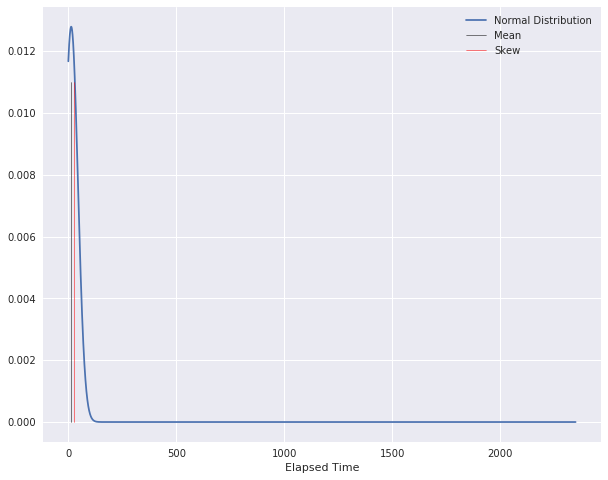

In [507]:
print("Let us plot a distibution of elapsed_time/user")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(b.Elapsed_Time, avg, sp.std(b.Elapsed_Time))
plt.plot(b.Elapsed_Time, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.011], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.011],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Elapsed Time")
plt.legend()
plt.show()

The elapsed_time/user is greater than 100 hours in only 333 cases
Let us take a closer look at the above distribution graph


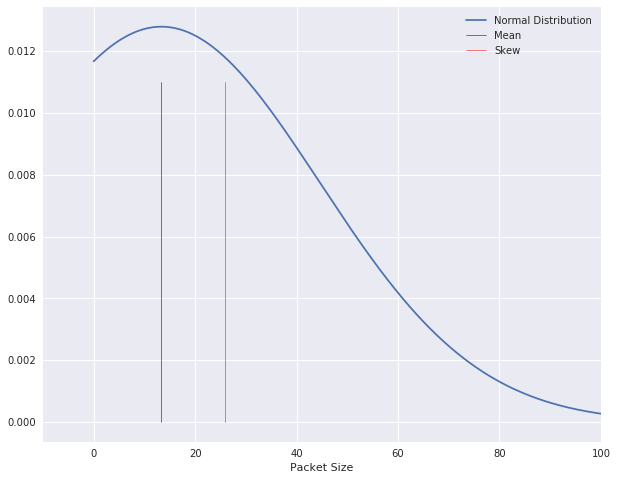

In [508]:
print("The elapsed_time/user is greater than 100 hours in only {} cases".format(sum(b.Elapsed_Time>100)))
print("Let us take a closer look at the above distribution graph")

plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(b.Elapsed_Time, avg, sp.std(b.Elapsed_Time))
plt.plot(b.Elapsed_Time,pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.011], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.011],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.xlim(-10,100)
plt.legend()
plt.show()

In [509]:
print("Lets plot the Distribution of Average Elapsed Time/User")
trace = go.Bar(x=np.arange(0,len(c)),y=b.Elapsed_Time)

layout=go.Layout(title='Distribution of Average Elapsed Time per User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='Average Elapsed Time per user'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Elapsed_Time')

Lets plot the Distribution of Average Elapsed Time/User
The draw time for this plot will be slow for clients without much RAM.


## 3. Traffic logs and incident data - For users in incident DB:

### <a id='11'> A. Distribution of Logs and User</a>

In [512]:
d=pd.DataFrame(traffic_logs.Source_User.value_counts())
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Count']
ind=d[d.Source_User.isin(threat_logs.Source_User)].index
z=d.iloc[ind,:]
d=[]
d=z.copy()

In [513]:
n,min_max,avg,var,skew,kurtosis=stats.describe(d.Count)
print(tabulate([['Unique Users',n],['Minimum #logs/user',min_max[0]], ["Maximum #logs/User",min_max[1]],
               ['Average #logs/user',avg],['Std.dev #logs/user',sp.std(d.Count)],['Variance #logs/user',var],
                ['Skewness #logs/user',skew],['Kurtosis #logs/user',kurtosis], ['Std error of mean',stats.sem(d.Count)],
                ['Median #logs/user',np.median(d.Count)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the #logs/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data")
print("Also the mean is larger than the median which means we have a positive skew")



+---------------------+------------------+
| Measures            |           Values |
+=====================+==================+
| Unique Users        |     842.00000000 |
+---------------------+------------------+
| Minimum #logs/user  |      15.00000000 |
+---------------------+------------------+
| Maximum #logs/User  |   23575.00000000 |
+---------------------+------------------+
| Average #logs/user  |    1432.51900238 |
+---------------------+------------------+
| Std.dev #logs/user  |    1419.67936738 |
+---------------------+------------------+
| Variance #logs/user | 2017886.04541732 |
+---------------------+------------------+
| Skewness #logs/user |       6.44775481 |
+---------------------+------------------+
| Kurtosis #logs/user |      79.53145561 |
+---------------------+------------------+
| Std error of mean   |      48.95446094 |
+---------------------+------------------+
| Median #logs/user   |    1221.50000000 |
+---------------------+------------------+


We can cl

Let us plot a distibution of #Logs/user


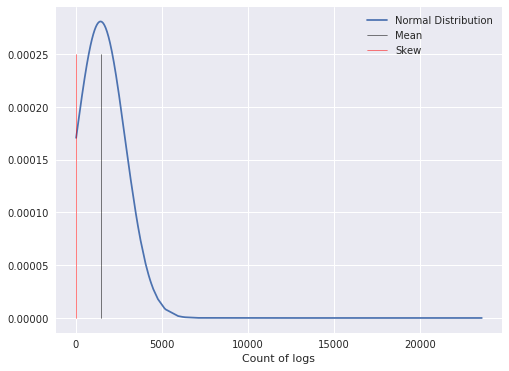

In [514]:
print("Let us plot a distibution of #Logs/user")
plt.figure(figsize=(8,6))
pdf = stats.norm.pdf(d.Count, avg, sp.std(d.Count))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00025], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.00025],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Count of logs")
plt.legend()
plt.show()

In [515]:
print("The number of logs/user is greater than 5000 in only {} cases".format(sum(d.Count>5000)))
print("Let us take a closer look at the above distribution graph")

The number of logs/user is greater than 5000 in only 14 cases
Let us take a closer look at the above distribution graph


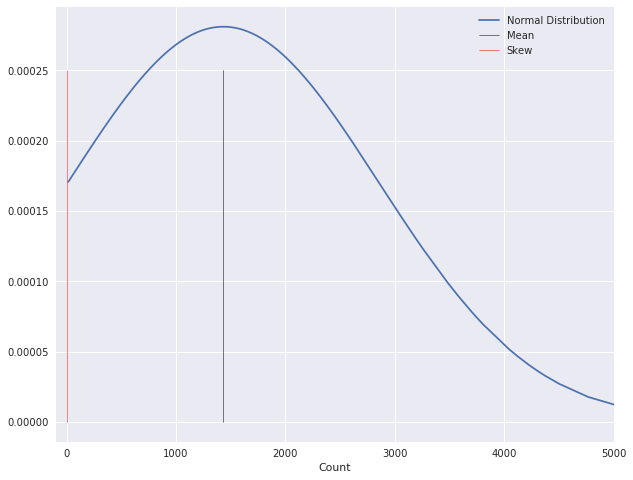

In [516]:
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(d.Count, avg, sp.std(d.Count))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00025], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.00025],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Count")
plt.legend()
plt.xlim(-100,5000)
plt.show()

Let us convert the count to log and then see the distribution


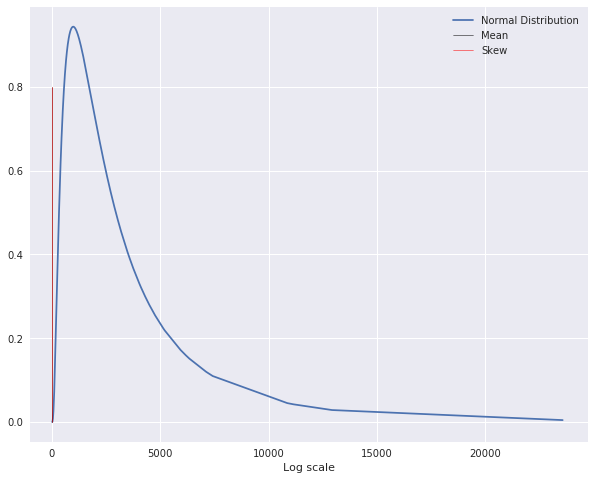

In [517]:
print("Let us convert the count to log and then see the distribution")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(np.log10(d.Count), np.mean(np.log10(d.Count)), sp.std(np.log10(d.Count)))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([np.log10(avg), np.log10(avg)], [0, 0.8], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([np.log10(skew),np.log10(skew)],[0 ,0.8],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlim(-1000)
plt.xlabel("Log scale")
plt.legend()
plt.show()

lets plot a box plot which will re-affirm the above results


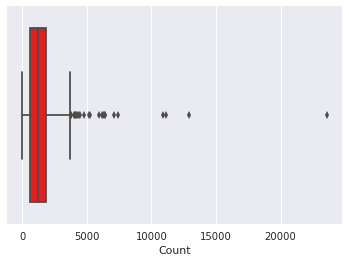

In [518]:
print("lets plot a box plot which will re-affirm the above results")
sns.boxplot(x=d.Count,color='red')
plt.show()

The boxplot shows the heavy skew in data


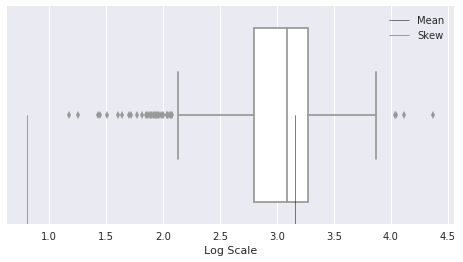

In [519]:
print("The boxplot shows the heavy skew in data")
plt.figure(figsize=(8,4))
sns.boxplot(x=np.log10(d.Count),color='white')
plt.plot([np.log10(avg), np.log10(avg)], [0, 15], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([np.log10(skew),np.log10(skew)],[0,10],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Log Scale")
plt.legend()
plt.show()

In [520]:
print("The below graph illustartes the distribution of number of logs per user.\nI have converted Source User names to integers for simplicity".format(traffic_logs.Source_User.nunique()))
trace=go.Bar(x=np.arange(0,len(z)),y=z.Count)
layout=go.Layout(title='Distribution of # Logs/User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='# of Logs'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Full_Traffic_Threat')

The below graph illustartes the distribution of number of logs per user.
I have converted Source User names to integers for simplicity


### <a id='12'> B. Distribution of size/user </a>

In [521]:
d=pd.DataFrame(traffic_logs.groupby(traffic_logs.Source_User).sum()['Bytes'])
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Bytes']
ind=d[d.Source_User.isin(threat_logs.Source_User)].index
z=d.iloc[ind,:]
z.sort_values(by='Bytes',inplace=True,ascending=True)
z.Bytes=z.Bytes/1000000.0
c=[]
c=z.copy()

In [522]:
print("Converted packet size from bytes to MB")
n,min_max,avg,var,skew,kurtosis=stats.describe(c.Bytes)
print(tabulate([['Unique Users',n],
               ['Average packet_size/user',avg],['Std.dev packet_size/user',sp.std(c.Bytes)],['Variance packet_size/user',var],
                ['Skewness packet_size/user',skew],['Kurtosis packet_size/user',kurtosis], ['Std error of mean',stats.sem(c.Bytes)],
                ['Median packet_size/user',np.median(c.Bytes)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the package_size/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data same as in previous cases")
print("Also the mean is larger than the median which means we have a positive skew")

Converted packet size from bytes to MB
+---------------------------+-----------------+
| Measures                  |          Values |
+===========================+=================+
| Unique Users              |    842.00000000 |
+---------------------------+-----------------+
| Average packet_size/user  |    291.68696252 |
+---------------------------+-----------------+
| Std.dev packet_size/user  |    495.23747039 |
+---------------------------+-----------------+
| Variance packet_size/user | 245551.78127215 |
+---------------------------+-----------------+
| Skewness packet_size/user |      6.70255715 |
+---------------------------+-----------------+
| Kurtosis packet_size/user |     77.76384519 |
+---------------------------+-----------------+
| Std error of mean         |     17.07715415 |
+---------------------------+-----------------+
| Median packet_size/user   |    149.01257800 |
+---------------------------+-----------------+


We can clearly see that the variance in the pac

Let us plot a distibution of packet_size/user


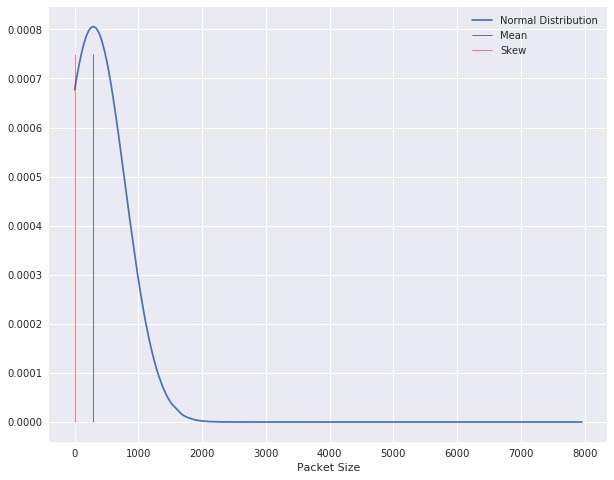

In [523]:
print("Let us plot a distibution of packet_size/user")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(c.Bytes, avg, sp.std(c.Bytes))
plt.plot(c.Bytes, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00075], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.00075],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.legend()
plt.show()

The packet_size/user is greater than 1GB in only 49 cases
Let us take a closer look at the above distribution graph


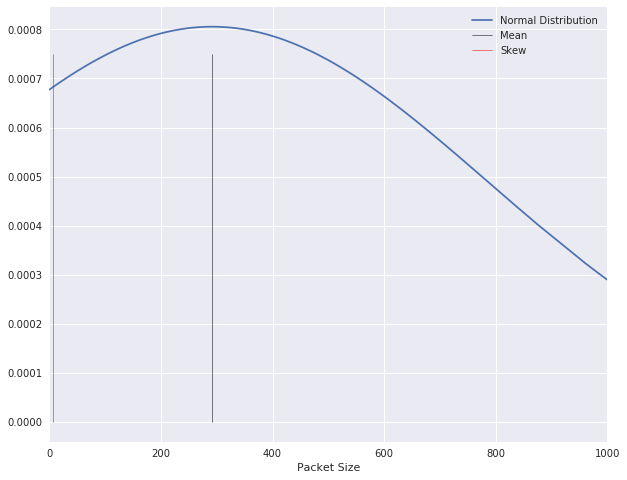

In [524]:
print("The packet_size/user is greater than 1GB in only {} cases".format(sum(c.Bytes>1000)))
print("Let us take a closer look at the above distribution graph")

plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(c.Bytes, avg, sp.std(c.Bytes))
plt.plot(c.Bytes, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00075], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.00075],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.xlim(0,1000)
plt.legend()
plt.show()

In [525]:
print("Lets plot the Distribution of Average Size/User")
trace = go.Bar(x=np.arange(0,len(z)),y=c.Bytes)

layout=go.Layout(title='Distribution of Average Size of Packets per User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='Average Size of Packets in MB'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Packets_Size_Traffic_Threat')

Lets plot the Distribution of Average Size/User


### <a id='13'>C. Distribution of Duration/User </a>

In [526]:
d=pd.DataFrame(traffic_logs.groupby(traffic_logs.Source_User).sum()['Elapsed_Time'])
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Elapsed_Time']
ind=d[d.Source_User.isin(threat_logs.Source_User)].index
z=d.iloc[ind,:]
z.sort_values(by='Elapsed_Time',inplace=True,ascending=True)
b=[]
b=z.copy()
b.Elapsed_Time=b.Elapsed_Time/3600.0

In [527]:
print("Converted Elapsed Time from seconds to hours")
n,min_max,avg,var,skew,kurtosis=stats.describe(b.Elapsed_Time)
print(tabulate([['Unique Users',n],
               ['Average elapsed time/user',avg],['Std.dev elapsed_time/user',sp.std(b.Elapsed_Time)],['Variance elapsed_time/user',var],
                ['Skewness elapsed_time/user',skew],['Kurtosis elapsed_time/user',kurtosis], ['Std error of mean',stats.sem(b.Elapsed_Time)],
                ['Median elapsed_time/user',np.median(b.Elapsed_Time)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the elapsed_time/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data same as in previous cases")
print("Also the mean is larger than the median which means we have a positive skew")

Converted Elapsed Time from seconds to hours
+----------------------------+---------------+
| Measures                   |        Values |
+============================+===============+
| Unique Users               |  842.00000000 |
+----------------------------+---------------+
| Average elapsed time/user  |   40.40974268 |
+----------------------------+---------------+
| Std.dev elapsed_time/user  |   48.43700255 |
+----------------------------+---------------+
| Variance elapsed_time/user | 2348.93292237 |
+----------------------------+---------------+
| Skewness elapsed_time/user |    7.30009119 |
+----------------------------+---------------+
| Kurtosis elapsed_time/user |   88.34550451 |
+----------------------------+---------------+
| Std error of mean          |    1.67024147 |
+----------------------------+---------------+
| Median elapsed_time/user   |   32.07277778 |
+----------------------------+---------------+


We can clearly see that the variance in the elapsed_time/use

Let us plot a distibution of elapsed_time/user


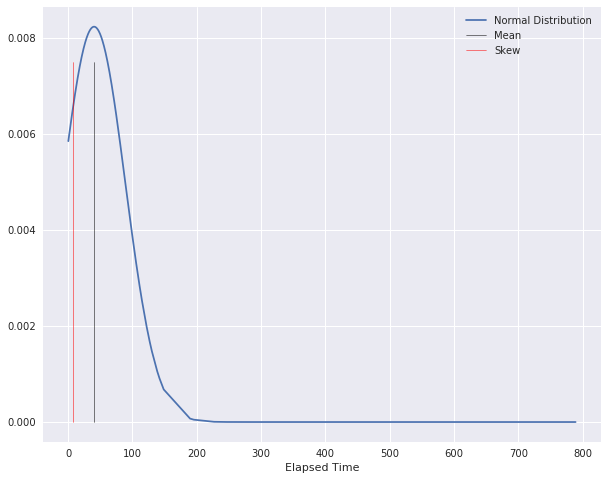

In [528]:
print("Let us plot a distibution of elapsed_time/user")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(b.Elapsed_Time, avg, sp.std(b.Elapsed_Time))
plt.plot(b.Elapsed_Time, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.0075], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.0075],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Elapsed Time")
plt.legend()
plt.show()

The elapsed_time/user is greater than 100 hours in only 40 cases
Let us take a closer look at the above distribution graph


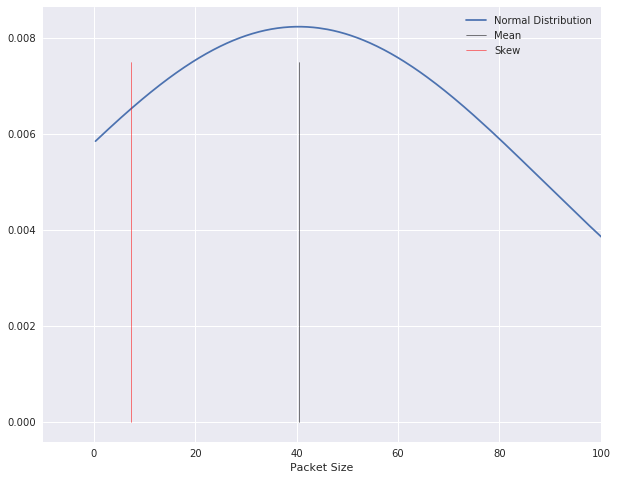

In [529]:
print("The elapsed_time/user is greater than 100 hours in only {} cases".format(sum(b.Elapsed_Time>100)))
print("Let us take a closer look at the above distribution graph")

plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(b.Elapsed_Time, avg, sp.std(b.Elapsed_Time))
plt.plot(b.Elapsed_Time,pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.0075], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.0075],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.xlim(-10,100)
plt.legend()
plt.show()

In [530]:
print("Lets plot the Distribution of Average Elapsed Time/User")
trace = go.Bar(x=np.arange(0,len(z)),y=b.Elapsed_Time)

layout=go.Layout(title='Distribution of Average Elapsed Time per User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='Average Elapsed Time per user'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Elapsed_Time_Traffic_threat')

Lets plot the Distribution of Average Elapsed Time/User


## 4. Traffic logs and incident data: For users NOT in incident DB:

### <a id='14'> A. Distribution of Logs and User</a>

In [532]:
d=pd.DataFrame(traffic_logs.Source_User.value_counts())
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Count']
ind=d[~d.Source_User.isin(threat_logs.Source_User)].index
z=d.iloc[ind,:]
d=[]
d=z.copy()

In [533]:
n,min_max,avg,var,skew,kurtosis=stats.describe(d.Count)
print(tabulate([['Unique Users',n],['Minimum #logs/user',min_max[0]], ["Maximum #logs/User",min_max[1]],
               ['Average #logs/user',avg],['Std.dev #logs/user',sp.std(d.Count)],['Variance #logs/user',var],
                ['Skewness #logs/user',skew],['Kurtosis #logs/user',kurtosis], ['Std error of mean',stats.sem(d.Count)],
                ['Median #logs/user',np.median(d.Count)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the #logs/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data")
print("Also the mean is larger than the median which means we have a positive skew")



+---------------------+------------------+
| Measures            |           Values |
+=====================+==================+
| Unique Users        |   46937.00000000 |
+---------------------+------------------+
| Minimum #logs/user  |       1.00000000 |
+---------------------+------------------+
| Maximum #logs/User  |  145869.00000000 |
+---------------------+------------------+
| Average #logs/user  |     492.48113429 |
+---------------------+------------------+
| Std.dev #logs/user  |    1130.37774684 |
+---------------------+------------------+
| Variance #logs/user | 1277781.07387814 |
+---------------------+------------------+
| Skewness #logs/user |      66.15390033 |
+---------------------+------------------+
| Kurtosis #logs/user |    7498.99205449 |
+---------------------+------------------+
| Std error of mean   |       5.21759736 |
+---------------------+------------------+
| Median #logs/user   |     191.00000000 |
+---------------------+------------------+


We can cl

Let us plot a distibution of #Logs/user


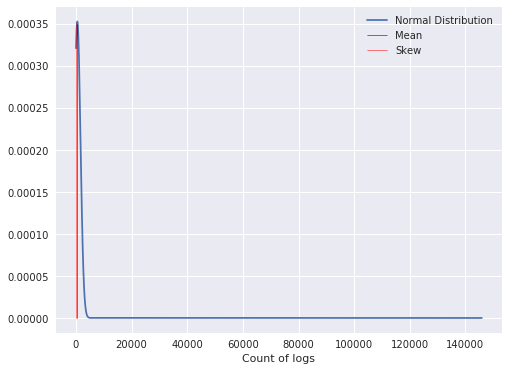

In [534]:
print("Let us plot a distibution of #Logs/user")
plt.figure(figsize=(8,6))
pdf = stats.norm.pdf(d.Count, avg, sp.std(d.Count))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00035], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0,0.00035],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Count of logs")
plt.legend()
plt.show()

In [535]:
print("The number of logs/user is greater than 5000 in only {} cases".format(sum(d.Count>5000)))
print("Let us take a closer look at the above distribution graph")

The number of logs/user is greater than 5000 in only 81 cases
Let us take a closer look at the above distribution graph


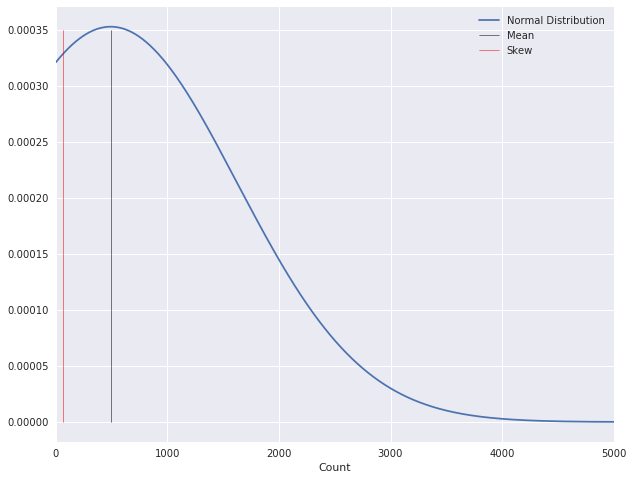

In [536]:
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(d.Count, avg, sp.std(d.Count))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.00035], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0,0.00035],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Count")
plt.legend()
plt.xlim(0,5000)
plt.show()

Let us convert the count to log and then see the distribution


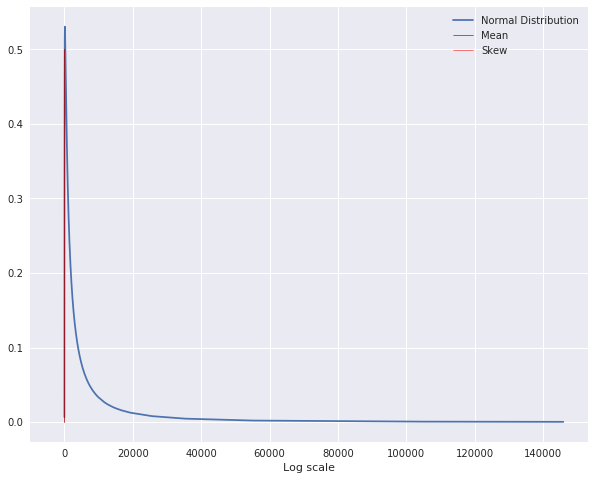

In [537]:
print("Let us convert the count to log and then see the distribution")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(np.log10(d.Count), np.mean(np.log10(d.Count)), sp.std(np.log10(d.Count)))
plt.plot(d.Count, pdf,label='Normal Distribution')
plt.plot([np.log10(avg), np.log10(avg)], [0, 0.5], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([np.log10(skew),np.log10(skew)],[0,0.5],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlim(-10000)
plt.xlabel("Log scale")
plt.legend()
plt.show()

lets plot a box plot which will re-affirm the above results


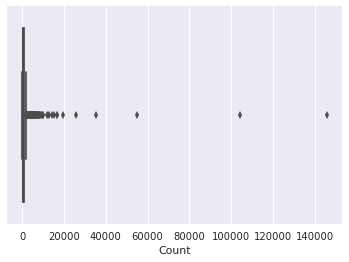

In [538]:
print("lets plot a box plot which will re-affirm the above results")
sns.boxplot(x=d.Count,color='red')
plt.show()

The boxplot shows the heavy skew in data


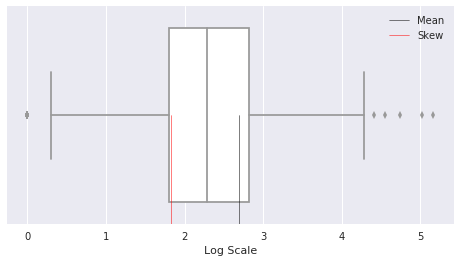

In [539]:
print("The boxplot shows the heavy skew in data")
plt.figure(figsize=(8,4))
sns.boxplot(x=np.log10(d.Count),color='white')
plt.plot([np.log10(avg), np.log10(avg)], [0, 15], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([np.log10(skew),np.log10(skew)],[0,10],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Log Scale")
plt.legend()
plt.show()

In [540]:
print("The below graph illustartes the distribution of number of logs per user.\nI have converted Source User names to integers for simplicity".format(traffic_logs.Source_User.nunique()))
trace=go.Bar(x=np.arange(0,len(z)),y=z.Count)
layout=go.Layout(title='Distribution of # Logs/User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='# of Logs'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Full_Traffic_Threat_NoT')

The below graph illustartes the distribution of number of logs per user.
I have converted Source User names to integers for simplicity
The draw time for this plot will be slow for clients without much RAM.


### <a id='15'> B. Distribution of size/user </a>

In [546]:
d=pd.DataFrame(traffic_logs.groupby(traffic_logs.Source_User).sum()['Bytes'])
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Bytes']
ind=d[~d.Source_User.isin(threat_logs.Source_User)].index
z=d.iloc[ind,:]
z.sort_values(by='Bytes',inplace=True,ascending=True)
z.Bytes=z.Bytes/1000000.0
c=[]
c=z.copy()

In [547]:
print("Converted packet size from bytes to MB")
n,min_max,avg,var,skew,kurtosis=stats.describe(c.Bytes)
print(tabulate([['Unique Users',n],
               ['Average packet_size/user',avg],['Std.dev packet_size/user',sp.std(c.Bytes)],['Variance packet_size/user',var],
                ['Skewness packet_size/user',skew],['Kurtosis packet_size/user',kurtosis], ['Std error of mean',stats.sem(c.Bytes)],
                ['Median packet_size/user',np.median(c.Bytes)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the packet size/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data same as in previous case")
print("Also the mean is larger than the median which means we have a positive skew")

Converted packet size from bytes to MB
+---------------------------+-----------------+
| Measures                  |          Values |
+===========================+=================+
| Unique Users              |  46937.00000000 |
+---------------------------+-----------------+
| Average packet_size/user  |    100.18683802 |
+---------------------------+-----------------+
| Std.dev packet_size/user  |    341.04424608 |
+---------------------------+-----------------+
| Variance packet_size/user | 116313.65586159 |
+---------------------------+-----------------+
| Skewness packet_size/user |     16.99595809 |
+---------------------------+-----------------+
| Kurtosis packet_size/user |    563.42312017 |
+---------------------------+-----------------+
| Std error of mean         |      1.57419196 |
+---------------------------+-----------------+
| Median packet_size/user   |     10.81264000 |
+---------------------------+-----------------+


We can clearly see that the variance in the pac

Let us plot a distibution of packet_size/user


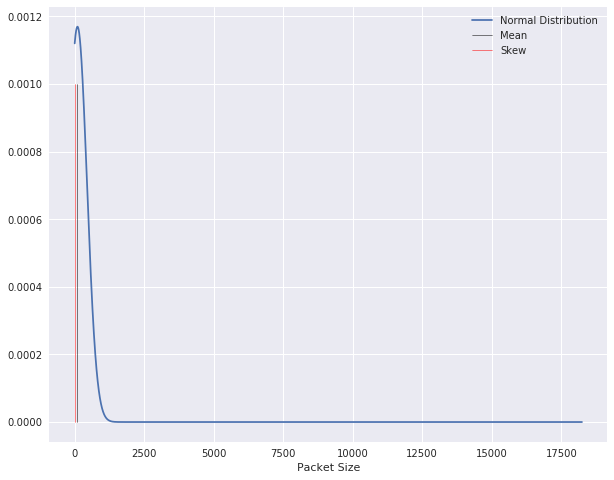

In [550]:
print("Let us plot a distibution of packet_size/user")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(c.Bytes, avg, sp.std(c.Bytes))
plt.plot(c.Bytes, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.001], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.001],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.legend()
plt.show()

The packet_size/user is greater than 5GB in only 32 cases
Let us take a closer look at the above distribution graph


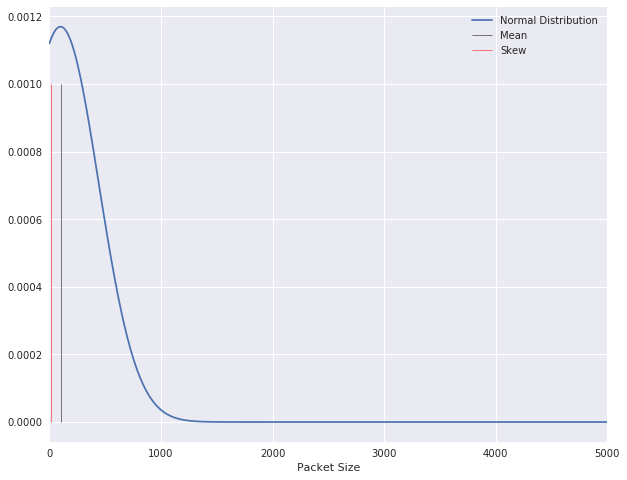

In [557]:
print("The packet_size/user is greater than 5GB in only {} cases".format(sum(c.Bytes>5000)))
print("Let us take a closer look at the above distribution graph")

plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(c.Bytes, avg, sp.std(c.Bytes))
plt.plot(c.Bytes, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.001], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.001],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.xlim(0,5000)
plt.legend()
plt.show()

In [558]:
print("Lets plot the Distribution of Average Size/User")
trace = go.Bar(x=np.arange(0,len(z)),y=c.Bytes)

layout=go.Layout(title='Distribution of Average Size of Packets per User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='Average Size of Packets in MB'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Packets_Size_Traffic_Threat_NoT')

Lets plot the Distribution of Average Size/User
The draw time for this plot will be slow for clients without much RAM.


### <a id='16'>C. Distribution of Duration/User </a>

In [559]:
d=pd.DataFrame(traffic_logs.groupby(traffic_logs.Source_User).sum()['Elapsed_Time'])
d.reset_index(inplace=True,drop=False)
d.columns=['Source_User','Elapsed_Time']
ind=d[~d.Source_User.isin(threat_logs.Source_User)].index
z=d.iloc[ind,:]
z.sort_values(by='Elapsed_Time',inplace=True,ascending=True)
b=[]
b=z
b.Elapsed_Time=b.Elapsed_Time/3600.0

In [560]:
print("Converted Elapsed Time from seconds to hours")
n,min_max,avg,var,skew,kurtosis=stats.describe(b.Elapsed_Time)
print(tabulate([['Unique Users',n],
               ['Average elapsed time/user',avg],['Std.dev elapsed_time/user',sp.std(b.Elapsed_Time)],['Variance elapsed_time/user',var],
                ['Skewness elapsed_time/user',skew],['Kurtosis elapsed_time/user',kurtosis], ['Std error of mean',stats.sem(b.Elapsed_Time)],
                ['Median elapsed_time/user',np.median(b.Elapsed_Time)]
               ],tablefmt='grid',floatfmt='.8f',headers=['Measures','Values']))
print("\n\nWe can clearly see that the variance in the elapsed_time/user is huge.")
print("At the same time the smaller standard deviation points to the fact that we have some outliers which are heavily skewing our data same as in previous cases")
print("Also the mean is larger than the median which means we have a positive skew")

Converted Elapsed Time from seconds to hours
+----------------------------+----------------+
| Measures                   |         Values |
+============================+================+
| Unique Users               | 46937.00000000 |
+----------------------------+----------------+
| Average elapsed time/user  |    12.86715768 |
+----------------------------+----------------+
| Std.dev elapsed_time/user  |    30.57407878 |
+----------------------------+----------------+
| Variance elapsed_time/user |   934.79420896 |
+----------------------------+----------------+
| Skewness elapsed_time/user |    27.38577139 |
+----------------------------+----------------+
| Kurtosis elapsed_time/user |  1427.07207679 |
+----------------------------+----------------+
| Std error of mean          |     0.14112383 |
+----------------------------+----------------+
| Median elapsed_time/user   |     4.59972222 |
+----------------------------+----------------+


We can clearly see that the variance in t

Let us plot a distibution of elapsed_time/user


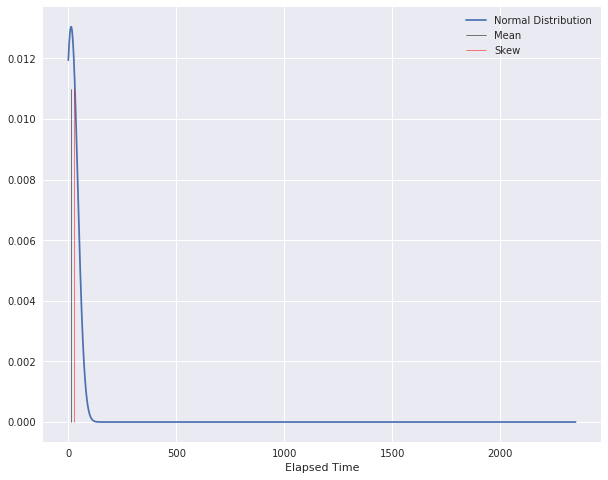

In [561]:
print("Let us plot a distibution of elapsed_time/user")
plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(b.Elapsed_Time, avg, sp.std(b.Elapsed_Time))
plt.plot(b.Elapsed_Time, pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.011], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.011],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Elapsed Time")
plt.legend()
plt.show()

The elapsed_time/user is greater than 100 hours in only 293 cases
Let us take a closer look at the above distribution graph


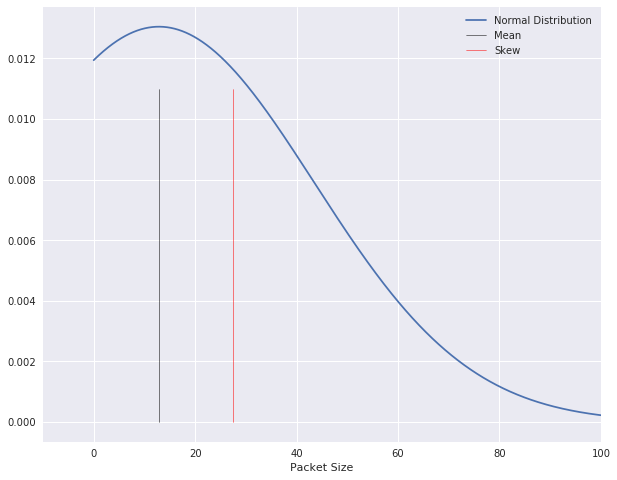

In [562]:
print("The elapsed_time/user is greater than 100 hours in only {} cases".format(sum(b.Elapsed_Time>100)))
print("Let us take a closer look at the above distribution graph")

plt.figure(figsize=(10,8))
pdf = stats.norm.pdf(b.Elapsed_Time, avg, sp.std(b.Elapsed_Time))
plt.plot(b.Elapsed_Time,pdf,label='Normal Distribution')
plt.plot([avg, avg], [0, 0.011], color='k', linestyle='-', linewidth=0.5,label='Mean')
plt.plot([skew,skew],[0, 0.011],color='r',linestyle='-',linewidth=0.5,label='Skew')
plt.xlabel("Packet Size")
plt.xlim(-10,100)
plt.legend()
plt.show()

In [563]:
print("Lets plot the Distribution of Average Elapsed Time/User")
trace = go.Bar(x=np.arange(0,len(z)),y=z.Elapsed_Time)

layout=go.Layout(title='Distribution of Average Elapsed Time per User',
                 xaxis=dict(title='Users',tickangle=0),
                 yaxis=dict(title='Average Elapsed Time per user'))
data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='Barplot_Elapsed_Time_Traffic_threat_NoT')

Lets plot the Distribution of Average Elapsed Time/User
The draw time for this plot will be slow for clients without much RAM.


In [77]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')